In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
import os

import bk.load
import bk.compute
import bk.plot
import bk.signal

import numpy as np
import pandas as pd

import scipy.signal
import scipy.stats as ss
import scipy.io

import matplotlib.pyplot as plt
import matplotlib as mpl
import neuroseries as nts
import basefunction.vBaseFunctions3
from tqdm import tqdm
import itertools

In [3]:
def save_fig(folder_path,name):
    import os
    old_path = os.getcwd()
    os.chdir(folder_path)
    plt.savefig(name)
    os.chdir(old_path)

def load_ripples():
    ripples_ = scipy.io.loadmat(f'{bk.load.session}-RippleFiring.mat')['ripples']['allsws'][0][0]
#     ripples_ = pd.DataFrame(data = ripples,columns=['start','peak','stop'])
    
    columns = ['start','peak','stop']
    
    ripples = {}
    for i,c in zip(range(ripples_.shape[1]),columns):
        ripples.update({c:nts.Ts(ripples_[:,i],time_units='s')})
    return ripples

def poissonTest(baseRate,counts,time):
    eps = np.spacing(1)
    
    lam = baseRate*time
    
    pInc = 1 - ss.poisson.cdf(counts,lam)
    pDec = ss.poisson.cdf(counts,lam)
    surprise = np.log((pDec+eps)/(pInc + eps))
    return pInc,pDec,surprise

def psth(neurons,stimulus,binSize,win,average = True):
    if isinstance(neurons,nts.time_series.Tsd): 
        neurons = np.array(neurons,'object')
    winLen = int((win[1] - win[0])/binSize)
    window = np.arange(winLen,dtype = int)-int(winLen/2)
    stim_bin = (stimulus/binSize).astype('int')
    t,binned = bk.compute.binSpikes(neurons,binSize,start = 0, stop = stimulus[-1]+win[-1])
    psth = np.empty((stimulus.size,len(neurons),winLen))
    
    for i,t in tqdm(enumerate(stim_bin)):
        psth[i] = binned[:,t+window]
    if average:    
        psth = np.mean(psth,0).T
    t = window*binSize
    return t,psth

# def correlogram(neuron1,neuron2,binSize,win):
    

In [4]:
def ripple_psth(path):  
    
    win = [-0.5,0.5]
    binSize = 0.005
    
    
    bk.load.current_session(path)
    ripples = load_ripples()
    
    neurons,metadata = bk.load.loadSpikeData(bk.load.path)
    
    ripples_ = ripples['peak'].as_units('s').index.values
    t,psth_ = psth(neurons,ripples_,binSize,win)
    
    states = bk.load.states()
    states.update({'ripples':nts.IntervalSet(ripples['start'].times(),ripples['stop'].times())})
    states.update({'outside_ripples':states['sws'].set_diff(nts.IntervalSet(states['ripples'].start-200_000,states['ripples'].end+200_000,force_no_fix=True)).drop_short_intervals(1)})
    
    
    
    pInc = np.empty(len(neurons))
    pDec = np.empty(len(neurons))
    surprise = np.empty(len(neurons))
    for i,n in enumerate(neurons):
        baseRate = len(n.restrict(states['outside_ripples']))/states['outside_ripples'].tot_length(time_units = 's')
        count = len(n.restrict(states['ripples']))
        time = states['ripples'].tot_length(time_units = 's')
        
        pInc[i],pDec[i],surprise[i] = poissonTest(baseRate,count,time)
    
    stats = pd.DataFrame(np.array([pInc,pDec,surprise]).T,columns=['pInc','pDec','surprise'])
    
    metadata = pd.concat([metadata,stats],1) 
    
    print(metadata)
    return t,psth_,metadata

In [4]:
def ripple_psth_slow(path):
    nbins = 100
    
    
    bk.load.current_session(path)
    ripples = load_ripples()
    neurons,metadata = bk.load.loadSpikeData(bk.load.path)

    win = [-0.5,0.5]
    n_neurons = len(neurons)
    
    peth = np.empty((len(ripples['peak'].as_units('s').index),nbins,n_neurons))
    
    for i,ripple_time in tqdm(enumerate(ripples['peak'].as_units('s').index)):
        t,binned = bk.compute.binSpikes(neurons,nbins=nbins,start = ripple_time+win[0],stop = ripple_time+win[1])
        peth[i,:] = binned.T
    
    
    states = bk.load.states()
    states.update({'ripples':nts.IntervalSet(ripples['start'].times(),ripples['stop'].times())})
    states.update({'outside_ripples':states['sws'].set_diff(nts.IntervalSet(states['ripples'].start-200_000,states['ripples'].end+200_000,force_no_fix=True))})
    
    pInc = np.empty(len(neurons))
    pDec = np.empty(len(neurons))
    surprise = np.empty(len(neurons))
    for i,n in enumerate(neurons):
        baseRate = len(n.restrict(states['outside_ripples']))/states['outside_ripples'].tot_length(time_units = 's')
        count = len(n.restrict(states['ripples']))
        time = states['ripples'].tot_length(time_units = 's')
        
        pInc[i],pDec[i],surprise[i] = poissonTest(baseRate,count,time)
    
    stats = pd.DataFrame(np.array([pInc,pDec,surprise]).T,columns=['pInc','pDec','surprise'])
    
    
    return t,peth,metadata,stats

In [5]:
batch = bk.load.batch(ripple_psth)
psthall = np.hstack([batch[s][1] for s in batch])
metaall = pd.concat([batch[s][2] for s in batch])

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [22:46<00:00, 22.40s/it]

Batch finished in 1366.1306083202362
Some session were not processed correctly
['Rat08-20130715', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140325', 'Rat09-20140326', 'Rat09-20140327', 'Rat09-20140328', 'Rat09-20140329', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140402', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140620', 'Rat11-20150323', 'Rat11-20150403']
37.704918032786885 %


In [207]:
win = [-0.5,0.5]
binSize = 0.005

bk.load.current_session()
ripples = load_ripples()

neurons,metadata = bk.load.loadSpikeData(bk.load.path)

ripples_ = ripples['peak'].as_units('s').index.values
t,psth_ = psth(neurons,ripples_,binSize,win,full = True)

Rat : 8 on day : 6
Working with session Rat08-20130713 @ Z:\Rat08\Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


5808it [00:01, 4517.69it/s]


In [10]:
temps = batch['Rat08-20130708'][0]

In [280]:
%matplotlib qt

In [283]:
@interact(i = (0,252))
def plot_pp(i = 18):
    plt.clf()
    plt.subplot(121)
    plt.imshow(psth_[:,i,:],aspect = 'auto')
    plt.clim([0, 1])
    plt.ylim([0,5000])
    plt.subplot(122)
    plt.bar(temps,np.mean(psth_[:,i,:],0),temps[1]-temps[0])

interactive(children=(IntSlider(value=18, description='i', max=252), Output()), _dom_classes=('widget-interact…

In [5]:
%time t,p = psth(neurons,neurons[0].as_units('s').index.values,0.001,[-0.1,0.1])

NameError: name 'neurons' is not defined

In [6]:
bk.load.current_session('Z:\Rat08\Rat08-20130708')

Rat : 8 on day : 1
Working with session Rat08-20130708 @ Z:\Rat08\Rat08-20130708


True

In [7]:
test = ripple_psth(bk.load.path)

Rat : 8 on day : 1
Working with session Rat08-20130708 @ Z:\Rat08\Rat08-20130708
Data already saved in Numpy format, loading them from here:
Rat08-20130708-neurons.npy
Rat08-20130708-metadata.npy


7536it [00:00, 12162.80it/s]


    Rat Day Shank Id Region Type          pInc          pDec   surprise
0     8   1     4  2    Hpc  Pyr  1.000000e+00  6.904731e-27 -36.043653
1     8   1     4  3    Hpc  Pyr  0.000000e+00  1.000000e+00  36.043653
2     8   1     4  4    Hpc  Int  0.000000e+00  1.000000e+00  36.043653
3     8   1     4  5    Hpc  Pyr  0.000000e+00  1.000000e+00  36.043653
4     8   1     4  6    Hpc  Pyr  0.000000e+00  1.000000e+00  36.043653
..   ..  ..   ... ..    ...  ...           ...           ...        ...
161   8   1    20  2   None  Pyr  3.168839e-01  6.831161e-01   0.768129
162   8   1    20  3   None  Unk  9.820839e-01  1.791610e-02  -4.003977
163   8   1    20  4   None  Unk  0.000000e+00  1.000000e+00  36.043653
164   8   1    20  5   None  Unk  1.022152e-07  9.999999e-01  16.096186
165   8   1    20  6   None  Int  1.360023e-13  1.000000e+00  29.624473

[166 rows x 9 columns]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Region', ylabel='surprise'>

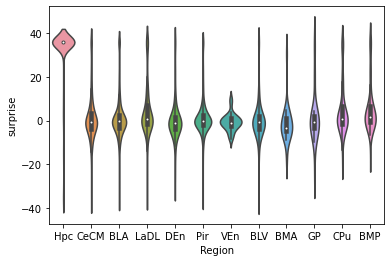

In [12]:
sns.violinplot(metaall[metaall['Region'] != 'None']['Region'],metaall[metaall['Region'] != 'None']['surprise'])

In [142]:
temps = batch['Rat08-20130710'][0]
a = np.unique(metaall.Region)
b = ['Pyr','Int']

@interact(stru = a,types = b,i = (0,200,1))
def plot(stru,types,i):
    mask = (metaall.pInc < 0.001) & (metaall.Region == stru) & (metaall.Type == types)
    mask = list(mask)
    psth = psthall[:,np.where(mask)[0]]
    meta = metaall[mask]

    zscore_p = scipy.stats.zscore(psth[:,i])
    g = scipy.signal.gaussian(10,1)
    g = g/np.sum(g)
    smooth_p = np.convolve(zscore_p,g,'same')

    plt.figure()
    plt.title(f'Rat : {meta.Rat.iloc[i]} Day : {meta.Day.iloc[i]} Shank : {meta.Shank.iloc[i]} Id :{meta.Id.iloc[i]}')
    plt.bar(temps,zscore_p,temps[1]-temps[0])
    plt.plot(temps,smooth_p,'r--')

interactive(children=(Dropdown(description='stru', options=('BLA', 'BLV', 'BMA', 'BMP', 'CPu', 'CeCM', 'DEn', …

In [201]:
%matplotlib inline

In [191]:
%matplotlib qt

In [124]:
stru = np.unique(metaall.Region)
types = ['Pyr']
stru = ['Hpc','BLA','Pir']
peak_times = {}
g = scipy.signal.gaussian(100,5)
g = g/np.sum(g)


for s,t in itertools.product(stru,types):
    mask = (metaall.pInc < 0.001) & (metaall.Region == s) & (metaall.Type == t)
    mask = list(mask)
    psth = psthall[:,np.where(mask)[0]]
    
    if np.sum(mask) <2:
        continue
#     psth_sm = scipy.signal.savgol_filter(psth,11,5,axis = 0)
    psth_sm = np.apply_along_axis(np.convolve,0,psth,g,'same')

#     plt.figure()
#     plt.imshow(scipy.stats.zscore(psth_sm).T,extent=(-0.5,0.5,0,psth.shape[1]),aspect='auto')
# #     plt.xticks(range(len(temps)), temps)
#     plt.figure()
    
    meta  = metaall[mask]
    peak  = np.argmax(psth_sm,0)
    order =  np.argsort(peak)
    print(s,t)
    peak_times.update({f'{s}-{t}':temps[peak]})


#     plt.imshow(scipy.stats.zscore(psth[:,order]).T,extent=(-0.5,0.5,0,psth.shape[1]),aspect='auto')
#     plt.title(stru)
#     plt.axvline(0,color = 'red')
#     for i,p in enumerate(psth.T):
#         zscore_p = scipy.stats.zscore(p)
#         g = scipy.signal.gaussian(10,1)
#         g = g/np.sum(g)
#         smooth_p = np.convolve(zscore_p,g,'same')
        
#         plt.figure()
#         plt.title(f'Rat : {meta.Rat.iloc[i]} Day : {meta.Day.iloc[i]} Shank : {meta.Shank.iloc[i]} Id :{meta.Id.iloc[i]}')
#         plt.bar(temps,zscore_p,temps[1]-temps[0])
#         plt.plot(temps,smooth_p,'r--')





Hpc Pyr
BLA Pyr
Pir Pyr


In [141]:
plt.

In [136]:
peak.shape

(55,)

In [122]:
plt.imshow(psth_sm[peak])

In [115]:
peak_v.shape

(21, 21)

(200, 21)

In [90]:
temps[peak]

-0.005

In [109]:
import seaborn as sns

In [110]:
df = pd.DataFrame.from_dict(peak_times, orient='index').T

In [111]:
%matplotlib qt

In [112]:
plt.title('Peak PSTH relative to ripples peak')
sns.violinplot(data = df)
plt.ylabel('Time(s)')
plt.axhline(0,color = 'r')

In [80]:
for key in peak_times:
    print(key,np.mean(peak_times[key]))

Hpc-Pyr -0.0036995753715498942
BLA-Pyr 0.03364516129032258
Pir-Pyr 0.06418181818181817


In [39]:
pd.isna(np.array(data))

NameError: name 'data' is not defined

In [ ]:
stru = np.unique(metaall.Region)
types = ['Pyr','Int']
stru = ['Hpc','BLA']
for s,t in itertools.product(stru,types):
    mask = (metaall.pInc < 0.001) & (metaall.Region == s) & (metaall.Type == t)
    mask = list(mask)
    
    psth_stru_types_u = np.nanmean(psthall[:,np.where(mask)[0]],1)
    
    mask = (metaall.pDec < 0.001) & (metaall.Region == s) & (metaall.Type == t)
    mask = list(mask)
    psth_stru_types_d = np.nanmean(psthall[:,np.where(mask)[0]],1)
    
    plt.figure()
    
    plt.suptitle(f'{s} and {t}')
    
    plt.subplot(1,2,1)
    plt.title('Up-Mod')
    plt.bar(temps,psth_stru_types_u,0.002,alpha = 0.5)
    plt.axvline(0,color = 'r',alpha = 0.5)
    
    plt.xlim(-0.5,0.5)
    
    plt.subplot(1,2,2)
    plt.title('Down-Mod')
    plt.bar(temps,psth_stru_types_d,0.002,alpha = 0.5)
    plt.axvline(0,color = 'r',alpha = 0.5)
    plt.xlim(-0.5,0.5)

    
    plt.tight_layout()
#     save_fig('P:/Data/Figures/',f'{s}-{t}-0.002-full.svg')
#     save_fig('P:/Data/Figures/',f'{s}-{t}-0.002-full.png')
    